# VAE

In [1]:
USE_SERVER = True
if USE_SERVER:
    !pip install elasticsearch
    !pip install elasticsearch_dsl
    !pip install pymed
    !pip install gensim
    !pip install torchsummary

  Using cached elasticsearch-7.8.0-py2.py3-none-any.whl (188 kB)
  Using cached elasticsearch_dsl-7.2.1-py2.py3-none-any.whl (53 kB)
  Using cached pymed-0.8.9-py3-none-any.whl (9.6 kB)
     |████████████████████████████████| 24.2 MB 94 kB/s s eta 0:00:01
  Using cached smart_open-2.1.0.tar.gz (116 kB)
  Created wheel for smart-open: filename=smart_open-2.1.0-py3-none-any.whl size=110317 sha256=3490bea4fe0e3d1751f43e026e19f1702cfea2dcee62e3d8b6135e5b7ca9d362
  Stored in directory: /home/ubuntu/.cache/pip/wheels/a4/9b/d5/85705a7ab783cd6f7bd718f01d3b1396272f30044e3c36401a
Successfully built smart-open
  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [3]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import utils
import os
from utils import PROJECT_ROOT, DATA_PATH
import yuval_module.paper_source as PaperSource

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

import py_4.get_mesh_vec as get_mesh_vec
import py_3.sim_matrix_3 as sim_matrix_3
import py_4.get_all_features as get_all_features 

from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
mesh_embed=get_mesh_vec.MeshEmbeddings(PROJECT_ROOT + "data/mesh_data/MeSHFeatureGeneratedByDeepWalk.csv")

In [6]:
FILE = "enriched_labeled_dataset_large" 
if os.path.exists(PROJECT_ROOT + DATA_PATH + FILE):
    print("READING FROM LOCAL")
    if FILE.split(".")[1] == "json":
        df = pd.read_json(PROJECT_ROOT + DATA_PATH + FILE)
    else:
        df = pd.read_csv(PROJECT_ROOT + DATA_PATH + FILE)
    #ps = PaperSource()
else:
    print("PULLING FROM S3")
    ps = sim_matrix_3.load_dataset(FILE)
    df = ps.get_dataset()

df.drop(columns=["last_author_country"],inplace=True)
df.rename(columns={'ORG_STATE':'last_author_country'},inplace=True)

print("FILE PULLED")

PULLING FROM S3
FILE PULLED


### Run VAE 

In [7]:
cd ..

/home/ubuntu/AYP


In [8]:
auth_core = pd.read_csv("data/train_set_author_names.csv")["0"]
auth_eps = pd.read_csv("data/val_set_author_names.csv")["0"]
auth_usecase = pd.read_csv("data/test_set_author_names.csv")["0"]

In [63]:
selection_train = list(set(df['last_author_name']) - set(auth_usecase))[:4000]
selection_test = list(set(df['last_author_name']) - set(auth_usecase))[4000:4500]

In [197]:
#settings

BATCH_SIZE= 32
EPOCHS = 30
cuda = torch.cuda.is_available()
seed = 42
log_interval = 10
num_workers = 2

#check for cuda
device = torch.device('cuda' if cuda else 'cpu')

torch.manual_seed(seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

device

device(type='cuda')

In [198]:
all_vae = get_all_features.VAE_Features(df)

'/home/ubuntu/AYP/code/models/names_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.
'/home/ubuntu/AYP/code/models/co_authors_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.


In [243]:
df_nonan = df[np.invert(df['mesh'].isna())]

In [244]:
class ToyDS(Dataset):
    def __init__(self,df,selection,vae_features = None):
        super().__init__()
        self.df = df[df['last_author_name'].isin(selection)]
        if vae_features is None:
            print("Creating new VAE FEATURES")
            self.vae_features = get_all_features.VAE_Features(self.df)
        else:
            print("Using pre-defined VAE FEATURES")
            self.vae_features = vae_features
        self.features = self.vae_features.get_all_features(self.df)
        print(list(self.vae_features.mesh_features.mesh_missing))
        self.input_dim = self.vae_features.input_dims
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features = self.features[idx]
        return features
    
    def __getvae__(self):
        return self.vae_features

In [245]:
train_set = ToyDS(df_nonan, selection_train, all_vae)
train_loader=DataLoader(dataset= train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES


/home/ubuntu/AYP/code/py_4/get_all_features.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  - co_authors to vector


Using old scaler
['MESH NAME NOT FOUND: Early Intervention, Educational', 'MESH NAME NOT FOUND: Dependency, Psychological', 'MESH NAME NOT FOUND: Reinforcement, Psychology', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Sphingosine-1-Phosphate Receptors', 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Lactate Dehydrogenase 5', 'MESH NAME NOT FOUND: Cyclophilin D', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Indigenous Peoples', 'MESH NAME NOT FOUND: Neural Networks, Computer', 'MESH NAME NOT FOUND: Protein-Arginine Deiminase Type 4', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: RNA, Circular', 'MESH NAME NOT FOUND: Outcome Assessment, Health Care', 'MESH NAME NOT FOUND: Broadly Neutralizing Antibodies', 'MESH NAME 

In [246]:
print("The number of features: ",train_set.input_dim)
print("The number of train data: ",train_set.__len__())

The number of features:  64
The number of train data:  20205


In [247]:
class VAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim = train_set.input_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc21 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc22 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc3 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.fc4 = nn.Linear(self.hidden_dim, self.input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return self.fc4(h)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [287]:
class VAE_GAUSSIAN(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim = train_set.input_dim):
        super(VAE_GAUSSIAN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc21 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc22 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc3 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.fc4 = nn.Linear(self.hidden_dim, self.input_dim)
        self.fc5 = nn.Linear(self.hidden_dim, self.input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decode(self, z):
        h = F.relu(self.fc3(z))
        mu = self.fc4(h)
        logvar = self.fc5(h)
        return mu, logvar

    def forward(self, x):
        mu_latent, logvar_latent = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu_latent, logvar_latent)
        mu_x, logvar_x = self.decode(z)
        return mu_latent, logvar_latent, mu_x, logvar_x
    
def loss_function_gaussian(x, mu_x, logvar_x, mu_latent, logvar_latent):
    # neg log likelihood of x under normal
#     loss_rec = np.log(2.0 * np.pi) + logvar_x + (x - mu_x)**2 / (2*torch.exp(logvar_x))
    
    loss_rec = -torch.sum((-0.5 * np.log(2.0 * np.pi)) + \
                          (-0.5 * logvar_x) + \
                          ((-0.5 / torch.exp(logvar_x)) * \
                           (targets - mu_x) ** 2.0), \
                          dim=dim,)
    KLD = -0.5 * torch.sum(1 + logvar_latent - mu_latent.pow(2) - logvar_latent.exp())
    return loss_rec + KLD

In [248]:
def loss_function(recon_x, x, mu, log_var):

#     MSE = F.l1_loss(recon_x, x.view(-1, train_set.input_dim))

#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
# #     KLD /= BATCH_SIZE * train_set.input_dim
    
# #     gamma = min(1.0,np.log(epoch+1))
#     assert(KLD >= 0)
    
    
    batch_size = x.size()[0]
    MSE =  F.mse_loss(recon_x, x)
    KLD_element = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
    KLD = torch.sum(KLD_element).mul_(-0.5) / batch_size
    assert(KLD >= 0)
    return MSE + KLD 

In [266]:
model = VAE(hidden_dim=32,latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters())

In [288]:
model_gaussian = VAE_GAUSSIAN(hidden_dim=32,latent_dim=2).to(device)
optimizer_gaussian = optim.Adam(model_gaussian.parameters())

In [289]:
model_gaussian

VAE_GAUSSIAN(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=2, bias=True)
  (fc22): Linear(in_features=32, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
)

In [290]:
def train_epoch_gaussian(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    
    with torch.no_grad():
        for epoch in range(num_epochs):
            print("Started training epoch no. {}".format(epoch+1))
            train_loss= 0
            for batch_idx, data in enumerate(train_loader):
                data = data.to(device, dtype=torch.float32)
                optimizer.zero_grad()
                mu_latent, logvar_latent, mu_x, logvar_x = model(data)
                loss = criterion(data, mu_x, logvar_x, mu_latent, logvar_latent)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
            print('====> Epoch: {} Average loss: {:.8f}\n'.format(
                epoch+1, train_loss / len(train_loader.dataset)))
            train_log.append({
                'epoch': epoch,
                'train_loss': train_loss / len(train_loader.dataset)})
    return train_log

In [291]:
train_epoch_gaussian(train_loader,model_gaussian,loss_function_gaussian,optimizer_gaussian,num_epochs= EPOCHS)

Started training epoch no. 1


NameError: name 'LOG_2_PI' is not defined

In [268]:
def train_epoch(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    
    with torch.no_grad():
        for epoch in range(num_epochs):
            print("Started training epoch no. {}".format(epoch+1))
            train_loss= 0
            for batch_idx, data in enumerate(train_loader):
                data = data.to(device, dtype=torch.float32)
                optimizer.zero_grad()
                recon_batch, mu, logvar = model(data)
                loss = criterion(recon_batch, data, mu, logvar)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
            print('====> Epoch: {} Average loss: {:.8f}\n'.format(
                epoch+1, train_loss / len(train_loader.dataset)))
            train_log.append({
                'epoch': epoch,
                'train_loss': train_loss / len(train_loader.dataset)})
    return train_log

In [269]:
def test_model(test_loader, model):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [270]:
train_log = train_epoch(train_loader,model,loss_function,optimizer,num_epochs= EPOCHS)

Started training epoch no. 1
====> Epoch: 1 Average loss: 0.03546811

Started training epoch no. 2
====> Epoch: 2 Average loss: 0.03513248

Started training epoch no. 3
====> Epoch: 3 Average loss: 0.03513636

Started training epoch no. 4
====> Epoch: 4 Average loss: 0.03510123

Started training epoch no. 5
====> Epoch: 5 Average loss: 0.03510537

Started training epoch no. 6
====> Epoch: 6 Average loss: 0.03510352

Started training epoch no. 7
====> Epoch: 7 Average loss: 0.03508825

Started training epoch no. 8
====> Epoch: 8 Average loss: 0.03508958

Started training epoch no. 9
====> Epoch: 9 Average loss: 0.03508858

Started training epoch no. 10
====> Epoch: 10 Average loss: 0.03509319

Started training epoch no. 11
====> Epoch: 11 Average loss: 0.03508764

Started training epoch no. 12
====> Epoch: 12 Average loss: 0.03508028

Started training epoch no. 13
====> Epoch: 13 Average loss: 0.03507506

Started training epoch no. 14
====> Epoch: 14 Average loss: 0.03507584

Started tr

In [271]:
train_log

[{'epoch': 0, 'train_loss': 0.03546810867585218},
 {'epoch': 1, 'train_loss': 0.035132484676754734},
 {'epoch': 2, 'train_loss': 0.03513636064246219},
 {'epoch': 3, 'train_loss': 0.035101230850729484},
 {'epoch': 4, 'train_loss': 0.03510536925682364},
 {'epoch': 5, 'train_loss': 0.03510351787254203},
 {'epoch': 6, 'train_loss': 0.035088248976797375},
 {'epoch': 7, 'train_loss': 0.035089577970101204},
 {'epoch': 8, 'train_loss': 0.0350885832820072},
 {'epoch': 9, 'train_loss': 0.035093188574927124},
 {'epoch': 10, 'train_loss': 0.035087644617264296},
 {'epoch': 11, 'train_loss': 0.035080279297416854},
 {'epoch': 12, 'train_loss': 0.03507506075662954},
 {'epoch': 13, 'train_loss': 0.03507583628961043},
 {'epoch': 14, 'train_loss': 0.03505581017031407},
 {'epoch': 15, 'train_loss': 0.03509026137474473},
 {'epoch': 16, 'train_loss': 0.035076801495456486},
 {'epoch': 17, 'train_loss': 0.03508815992825458},
 {'epoch': 18, 'train_loss': 0.035068959875349894},
 {'epoch': 19, 'train_loss': 0.03

In [272]:
test_set = ToyDS(df, selection_test, vae_features = train_set.__getvae__())
test_loader=DataLoader(dataset= test_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES


/home/ubuntu/AYP/code/py_4/get_all_features.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  - co_authors to vector


Using old scaler
['MESH NAME NOT FOUND: Early Intervention, Educational', 'MESH NAME NOT FOUND: Dependency, Psychological', 'MESH NAME NOT FOUND: Reinforcement, Psychology', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Sphingosine-1-Phosphate Receptors', 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Lactate Dehydrogenase 5', 'MESH NAME NOT FOUND: Cyclophilin D', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Indigenous Peoples', 'MESH NAME NOT FOUND: Neural Networks, Computer', 'MESH NAME NOT FOUND: Protein-Arginine Deiminase Type 4', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: RNA, Circular', 'MESH NAME NOT FOUND: Outcome Assessment, Health Care', 'MESH NAME NOT FOUND: Broadly Neutralizing Antibodies', 'MESH NAME 

In [273]:
test_model(test_loader, model)

====> Test set loss: 0.0326


In [274]:
data = torch.from_numpy(test_set.features).to(device,dtype=torch.float32)
x_hat_test, _, __ = model(data)

In [275]:
assert(test_set.features.shape==x_hat_test.shape)

In [276]:
np.mean(np.square(x_hat_test.detach().cpu().numpy() - test_set.features))

1.039353195358378

# Test

In [153]:
selection = [auth_usecase[109]]
print(df[df['last_author_name'].isin(selection)]["PI_IDS"].value_counts())

7127687     10
10594466     8
11990780     1
Name: PI_IDS, dtype: int64


In [154]:
train_vae = train_set.__getvae__()
test_set = ToyDS(df, selection,train_vae)
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES
Using old scaler
['MESH NAME NOT FOUND: Female', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Male', 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', 'MESH NAME NOT FOUND: Outcome Assessment, Health Care', 'MESH NAME NOT FOUND: Diet, Healthy', 'MESH NAME NOT FOUND: Copper-Transporting ATPases']


/home/ubuntu/AYP/code/py_4/get_all_features.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


In [155]:
bottle_neck=[]
recon_batchs = []
for batch_idx, data in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            recon_batch, mu, logvar, _= model(data)
            if cuda:
                bottle_neck.extend(mu.cpu().detach().numpy())
                recon_batchs.extend(recon_batch.cpu().detach().numpy())
            else:
                bottle_neck.extend(mu.detach().numpy())
                recon_batchs.extend(recon_batch.detach().numpy())
bottle_neck = np.array(bottle_neck)
recon_batchs = np.array(recon_batchs)
print(bottle_neck.shape)
print(recon_batchs.shape)

(19, 32)
(19, 64)


In [157]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=1, n_iter=1000,random_state=42)
tsne_results = tsne.fit_transform(bottle_neck)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.634541
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.133377
[t-SNE] KL divergence after 1000 iterations: 0.337330
t-SNE done! Time elapsed: 0.14081168174743652 seconds


In [158]:
df_subset=pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

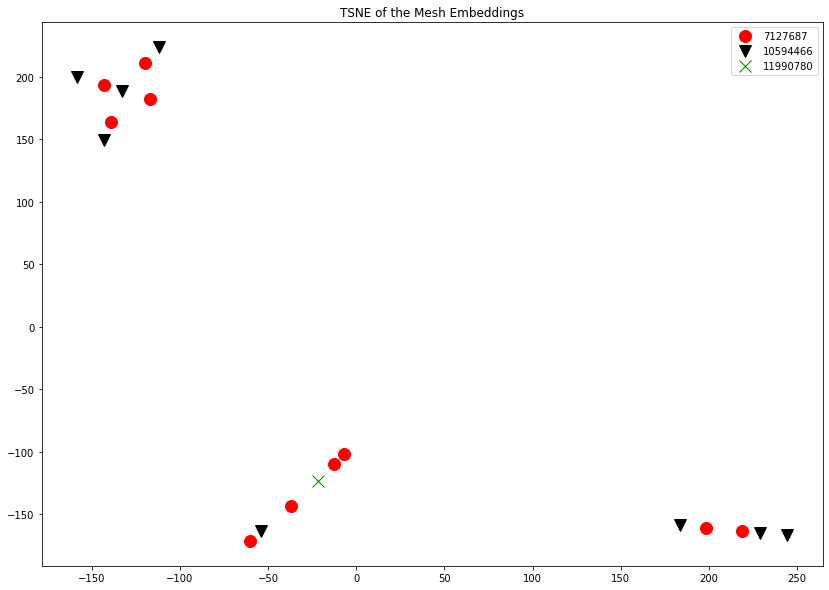

In [159]:
groups = df_subset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### SANITY TESTS

#### ON INPUT DIM:

In [160]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000, random_state=42)
tsne_inputs = tsne.fit_transform(test_set.features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
input_testset=pd.DataFrame()
input_testset['tsne-2d-one'] = tsne_inputs[:,0]
input_testset['tsne-2d-two'] = tsne_inputs[:,1]
input_testset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.712021
[t-SNE] KL divergence after 1000 iterations: 0.240680
t-SNE done! Time elapsed: 0.14115023612976074 seconds


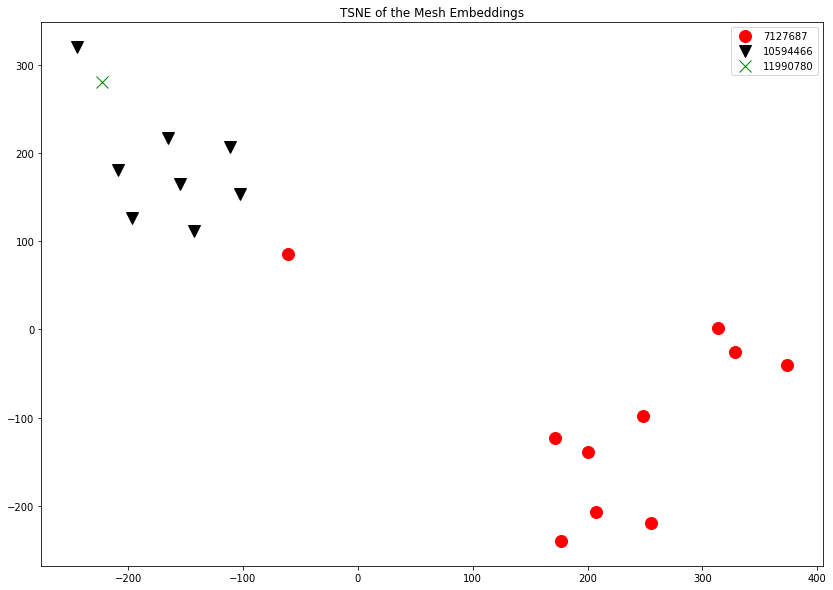

In [161]:
groups = input_testset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### OUTPUT DIMS

In [162]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000,random_state=42)
tsne_output = tsne.fit_transform(recon_batchs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
output_testset=pd.DataFrame()
output_testset['tsne-2d-one'] = tsne_output[:,0]
output_testset['tsne-2d-two'] = tsne_output[:,1]
output_testset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.000622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.051392
[t-SNE] KL divergence after 1000 iterations: 0.264274
t-SNE done! Time elapsed: 0.14203095436096191 seconds


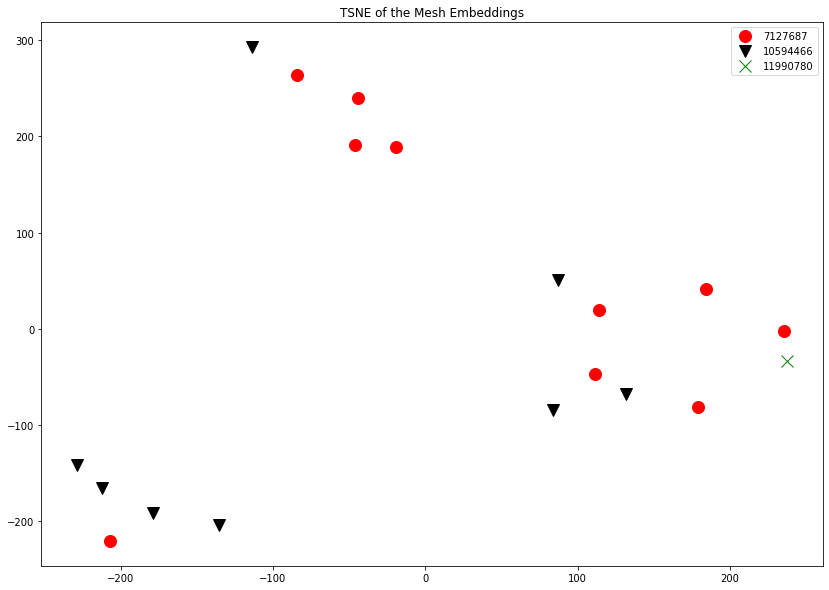

In [163]:
groups = output_testset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### NO MANS LAND

In [418]:
test_set.features[0]

array([-0.50199129, -0.55304408, -1.11197024,  0.13279847,  0.65093502,
       -0.42050131,  0.25626781, -0.21144755,  1.99238554, -0.29889596,
        0.15860426,  0.45733381, -0.34631883,  0.4325539 ,  0.85681164,
        0.17159677, -0.40004916, -0.07162718,  0.57666289,  1.49306876,
        0.47493495,  0.97225905,  0.34451381,  0.64073872, -1.28121672,
       -0.33810474,  0.43066876, -0.11457027,  0.3945722 ,  0.64803686,
       -0.13211849,  0.02283041,  0.67664781,  0.2118174 , -1.59962644,
       -0.05133112,  0.01799207,  0.47685679, -1.74260471, -1.84183656,
       -1.13033742,  0.86080341,  0.29407667,  0.55475597, -0.17450885,
       -0.39631865,  0.24888995, -0.16209635, -0.69429282,  0.25973779,
        0.70000427,  0.03619969,  0.90741422,  0.47145351,  0.52880774,
       -0.05796083,  0.26039517,  0.20660807, -0.12759649, -0.59140659,
       -0.28420128,  0.02718099,  1.73989786, -0.01139748])

In [419]:
x_hat_test[0]

array([-0.27714178, -1.0017875 , -0.8660377 , -1.3950189 ,  0.31925023,
       -0.23967588, -0.7128467 , -0.544175  ,  0.49177524,  0.19092607,
       -0.4768385 , -0.05419488, -0.78542185, -0.58475316,  0.51393145,
        0.4190841 , -0.14231044,  0.06364942,  0.03426949,  0.3288126 ,
        0.5649104 ,  0.8606392 ,  0.5308924 ,  0.05233103, -0.3207164 ,
       -0.37507668, -0.32485735, -0.16376626, -0.09218411, -1.0987935 ,
        0.5924798 , -0.4320191 ,  0.37508345, -0.01535261, -0.5751231 ,
        0.3135656 , -0.70878136, -0.2714462 , -0.53419185,  0.59531003,
       -0.7704554 ,  0.07954943,  0.37700552,  0.38243893,  0.06204695,
       -0.30105564, -0.02034771,  0.17617917,  0.53712463,  0.10309541,
       -0.09731984,  0.56918436,  0.0667811 , -0.1419054 ,  0.19347173,
       -0.4024818 ,  0.5618698 ,  0.28563982,  1.0215642 ,  0.3107661 ,
       -0.20175737, -0.04989976,  0.1086669 ,  0.21210732], dtype=float32)